In [1]:
# Import the dependencies.
# Mandatory
from sqlalchemy import create_engine, text, inspect

# ORM imports - for classes
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine, func, case
from sqlalchemy.orm import Session
from sqlalchemy.ext.declarative import declarative_base

#data science
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Other imports
import datetime as dt

# Import DB credentials
import config as cfg

## Connecting to Postgres

In [2]:
# Setup the SQL connection variables
SQL_USERNAME = cfg.SQL_USERNAME
SQL_PASSWORD = cfg.SQL_PASSWORD
SQL_IP = cfg.SQL_IP
SQL_PORT = cfg.SQL_PORT
DATABASE = cfg.DATABASE

In [3]:
# Connect to PostgreSQL server
connection_string = f'postgresql+psycopg2://{SQL_USERNAME}:{SQL_PASSWORD}@{SQL_IP}:{SQL_PORT}/{DATABASE}'
engine = create_engine(connection_string)

In [4]:
# explore and understand the data

# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# Using the inspector to print the column names within each table and its types
for table in tables:
    print(table)
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])
        
    print()

contact
contact_id INTEGER
first_name VARCHAR(30)
last_name VARCHAR(30)
email VARCHAR(50)
last_update TIMESTAMP

campaign
funding_id INTEGER
contact_id INTEGER
company_name VARCHAR(50)
description VARCHAR(75)
goal NUMERIC
pledged NUMERIC
outcome VARCHAR(10)
backers_count INTEGER
country VARCHAR(2)
currency VARCHAR(3)
launched_date TIMESTAMP
end_date TIMESTAMP
staff_pick BOOLEAN
spotlight BOOLEAN
category_id VARCHAR(10)
subcategory_id VARCHAR(12)
last_update TIMESTAMP

category
category_id VARCHAR(10)
category VARCHAR(50)
last_update TIMESTAMP

subcategory
subcategory_id VARCHAR(12)
subcategory VARCHAR(50)
last_update TIMESTAMP



In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

# Print all of the classes mapped to the Base
print(list(Base.classes))

[<class 'sqlalchemy.ext.automap.subcategory'>, <class 'sqlalchemy.ext.automap.campaign'>, <class 'sqlalchemy.ext.automap.category'>, <class 'sqlalchemy.ext.automap.contact'>]


In [6]:
# THIS IS ORM STUFF TO DEFINE CLASSES

# Assign the classes to variables
# documentation from https://docs.sqlalchemy.org/en/14/orm/extensions/automap.html - Reference Basic Use
Contact = Base.classes.contact
Campaign = Base.classes.campaign
Category = Base.classes.category
Subcategory = Base.classes.subcategory

# Create a session
session = Session(engine)

## Single DataFrame combining all 4 tables (contacts, campaigns, categories and subcategories)

#### Method 1: SQL Statement

In [38]:
query = """
		SELECT
			cont.first_name,
			cont.last_name,
			cont.email,
			camp.company_name,
			camp.description,
			camp.goal,
			camp.pledged,
			camp.outcome,
			camp.backers_count,
			camp.country,
			camp.currency,
			camp.launched_date,
			camp.end_date,
			camp.staff_pick,
			camp.spotlight,
			cat.category,
			sub.subcategory
		FROM
			public.contact cont
		JOIN public.campaign camp
			ON cont.contact_id = camp.contact_id
		JOIN public.category cat
			ON camp.category_id = cat.category_id
		JOIN public.subcategory sub
			ON camp.subcategory_id = sub.subcategory_id
		;
		"""

full_data_sql_df = pd.read_sql(text(query), con=engine)
full_data_sql_df.head()

,first_name,last_name,email,company_name,description,goal,pledged,outcome,backers_count,country,currency,launched_date,end_date,staff_pick,spotlight,category,subcategory
0,Cecilia,Velasco,cecilia.velasco@rodrigues.fr,"Baldwin, Riley and Jackson",Pre-emptive tertiary standardization,100.0,0.0,failed,0,CA,CAD,2020-02-13 06:00:00,2021-03-01 06:00:00,False,False,food,food trucks
1,Adam,Zavala,adam.zavala@guichard.fr,Werner-Bryant,Virtual uniform frame,1800.0,7991.0,successful,222,US,USD,2020-06-20 05:00:00,2021-01-30 06:00:00,False,False,food,food trucks
2,Rosie,Peltier,rosie.peltier@voila.fr,Stewart LLC,Cloned bi-directional architecture,1300.0,12047.0,successful,113,US,USD,2020-11-29 06:00:00,2021-06-11 05:00:00,False,False,food,food trucks
3,Sarah,Davis,sarah.davis@david.com,Castillo-Carey,Cross-platform solution-oriented process impro...,142400.0,21307.0,failed,296,US,USD,2020-05-05 05:00:00,2021-05-30 05:00:00,False,False,food,food trucks
4,Melissa,Canali,melissa.canali@libero.it,"Wright, Hartman and Yu",User-friendly tertiary array,3300.0,12437.0,successful,131,US,USD,2021-01-29 06:00:00,2021-02-13 06:00:00,False,False,food,food trucks


#### Method 2: ORM

In [7]:
results = session.query(
    Contact.first_name,
    Contact.last_name,
    Contact.email,
    Campaign.company_name,
    Campaign.description,
    Campaign.goal,
    Campaign.pledged,
    Campaign.outcome,
    Campaign.backers_count,
    Campaign.country,
    Campaign.currency,
    Campaign.launched_date,
    Campaign.end_date,
    Campaign.staff_pick,
    Campaign.spotlight,
    Category.category,
    Subcategory.subcategory
).join(
    Campaign, Contact.contact_id == Campaign.contact_id
).join(
    Category, Campaign.category_id == Category.category_id
).join(
    Subcategory, Campaign.subcategory_id == Subcategory.subcategory_id
).all()

# Convert results to a pandas DataFrame
full_data_orm_df = pd.DataFrame(results, columns=[
    'first_name', 'last_name', 'email', 'company_name', 'description', 'goal', 'pledged', 
    'outcome', 'backers_count', 'country', 'currency', 'launched_date', 'end_date', 
    'staff_pick', 'spotlight', 'category', 'subcategory'
])

# Display the DataFrame
full_data_orm_df.head()

,first_name,last_name,email,company_name,description,goal,pledged,outcome,backers_count,country,currency,launched_date,end_date,staff_pick,spotlight,category,subcategory
0,Cecilia,Velasco,cecilia.velasco@rodrigues.fr,"Baldwin, Riley and Jackson",Pre-emptive tertiary standardization,100.0,0.0,failed,0,CA,CAD,2020-02-13 06:00:00,2021-03-01 06:00:00,False,False,food,food trucks
1,Adam,Zavala,adam.zavala@guichard.fr,Werner-Bryant,Virtual uniform frame,1800.0,7991.0,successful,222,US,USD,2020-06-20 05:00:00,2021-01-30 06:00:00,False,False,food,food trucks
2,Rosie,Peltier,rosie.peltier@voila.fr,Stewart LLC,Cloned bi-directional architecture,1300.0,12047.0,successful,113,US,USD,2020-11-29 06:00:00,2021-06-11 05:00:00,False,False,food,food trucks
3,Sarah,Davis,sarah.davis@david.com,Castillo-Carey,Cross-platform solution-oriented process impro...,142400.0,21307.0,failed,296,US,USD,2020-05-05 05:00:00,2021-05-30 05:00:00,False,False,food,food trucks
4,Melissa,Canali,melissa.canali@libero.it,"Wright, Hartman and Yu",User-friendly tertiary array,3300.0,12437.0,successful,131,US,USD,2021-01-29 06:00:00,2021-02-13 06:00:00,False,False,food,food trucks


## staff picks or spotlight that reached their funding goal

#### Method 1: SQL Statement

In [8]:
query = """
		SELECT
			cont.first_name,
			cont.last_name,
			cont.email,
			camp.company_name,
			camp.description,
			camp.goal,
			camp.pledged,
			camp.outcome,
			camp.backers_count,
			camp.country,
			camp.currency,
			camp.launched_date,
			camp.end_date,
			camp.staff_pick,
			camp.spotlight,
			cat.category,
			sub.subcategory
		FROM
			public.contact cont
		JOIN public.campaign camp
			ON cont.contact_id = camp.contact_id
		JOIN public.category cat
			ON camp.category_id = cat.category_id
		JOIN public.subcategory sub
			ON camp.subcategory_id = sub.subcategory_id
        WHERE
            (staff_pick = TRUE OR spotlight = TRUE)
            AND pledged >= goal
        ORDER BY 
            pledged desc
		;
		"""

reached_goal_sql_df = pd.read_sql(text(query), con=engine)
reached_goal_sql_df.head()

,first_name,last_name,email,company_name,description,goal,pledged,outcome,backers_count,country,currency,launched_date,end_date,staff_pick,spotlight,category,subcategory
0,Severino,Linares,severino.linares@angeli.com,Perez Group,Cross-platform tertiary hub,63400.0,197728.0,successful,2038,US,USD,2021-05-01 05:00:00,2021-11-03 05:00:00,True,True,publishing,translations
1,Roberto,Guyot,roberto.guyot@bennett.com,"Hicks, Wall and Webb",Managed discrete framework,174500.0,197018.0,successful,2526,US,USD,2020-04-08 05:00:00,2021-04-15 05:00:00,False,True,theater,plays
2,Modesto,Wright,modesto.wright@pareto.com,"Baker, Collins and Smith",Reactive real-time software,114400.0,196779.0,successful,4799,US,USD,2021-09-13 05:00:00,2021-12-16 06:00:00,True,True,film & video,documentary
3,Darren,Bernardi,darren.bernardi@brooks-martin.com,Santana-George,Re-engineered client-driven knowledge user,71500.0,194912.0,successful,2320,US,USD,2021-03-16 05:00:00,2021-06-26 05:00:00,False,True,theater,plays
4,Gebhard,Thanel,gebhard.thanel@gmail.com,"Clarke, Anderson and Lee",Robust explicit hardware,191200.0,191222.0,successful,1821,US,USD,2021-05-22 05:00:00,2021-06-30 05:00:00,False,True,theater,plays


#### Method 2: ORM

In [9]:
# ORM to get all campaigns that have been staff picked or are in the spotlight and have reached their goal
results = session.query(
    Contact.first_name,
    Contact.last_name,
    Contact.email,
    Campaign.company_name,
    Campaign.description,
    Campaign.goal,
    Campaign.pledged,
    Campaign.outcome,
    Campaign.backers_count,
    Campaign.country,
    Campaign.currency,
    Campaign.launched_date,
    Campaign.end_date,
    Campaign.staff_pick,
    Campaign.spotlight,
    Category.category,
    Subcategory.subcategory
).join(
    Campaign, Contact.contact_id == Campaign.contact_id
).join(
    Category, Campaign.category_id == Category.category_id
).join(
    Subcategory, Campaign.subcategory_id == Subcategory.subcategory_id
).filter(
    (Campaign.staff_pick == True) | (Campaign.spotlight == True),
    Campaign.pledged >= Campaign.goal
).order_by(
    Campaign.pledged.desc()
).all()

# Convert results to a pandas DataFrame
reached_goal_orm_df = pd.DataFrame(results, columns=[
    'first_name', 'last_name', 'email', 'company_name', 'description', 'goal', 'pledged', 
    'outcome', 'backers_count', 'country', 'currency', 'launched_date', 'end_date', 
    'staff_pick', 'spotlight', 'category', 'subcategory'
])

# Display the DataFrame
reached_goal_orm_df.head()

,first_name,last_name,email,company_name,description,goal,pledged,outcome,backers_count,country,currency,launched_date,end_date,staff_pick,spotlight,category,subcategory
0,Severino,Linares,severino.linares@angeli.com,Perez Group,Cross-platform tertiary hub,63400.0,197728.0,successful,2038,US,USD,2021-05-01 05:00:00,2021-11-03 05:00:00,True,True,publishing,translations
1,Roberto,Guyot,roberto.guyot@bennett.com,"Hicks, Wall and Webb",Managed discrete framework,174500.0,197018.0,successful,2526,US,USD,2020-04-08 05:00:00,2021-04-15 05:00:00,False,True,theater,plays
2,Modesto,Wright,modesto.wright@pareto.com,"Baker, Collins and Smith",Reactive real-time software,114400.0,196779.0,successful,4799,US,USD,2021-09-13 05:00:00,2021-12-16 06:00:00,True,True,film & video,documentary
3,Darren,Bernardi,darren.bernardi@brooks-martin.com,Santana-George,Re-engineered client-driven knowledge user,71500.0,194912.0,successful,2320,US,USD,2021-03-16 05:00:00,2021-06-26 05:00:00,False,True,theater,plays
4,Gebhard,Thanel,gebhard.thanel@gmail.com,"Clarke, Anderson and Lee",Robust explicit hardware,191200.0,191222.0,successful,1821,US,USD,2021-05-22 05:00:00,2021-06-30 05:00:00,False,True,theater,plays


## Count of categories by outcome

#### Method 1: SQL Statement

In [17]:
query = """
		SELECT
			category,
			SUM(canceled) AS canceled,
			SUM(failed) AS failed,
			SUM(live) AS live,
			SUM(successful) AS successful,
			COUNT(category) AS grand_total
		FROM
			(
			SELECT
				cat.category,
				CASE WHEN camp.outcome = 'canceled' then 1 else 0 END AS canceled,
				CASE WHEN camp.outcome = 'failed' then 1 else 0 END AS failed,
				CASE WHEN camp.outcome = 'live' then 1 else 0 END AS live,
				CASE WHEN camp.outcome = 'successful' then 1 else 0 END AS successful
			FROM
				public.campaign camp
			JOIN public.category cat
				ON cat.category_id = camp.category_id
			)
		GROUP BY
			category
        ORDER BY
            grand_total desc
		;
		"""

count_of_categories_by_outcome_sql_df = pd.read_sql(text(query), con=engine)
count_of_categories_by_outcome_sql_df.head()

,category,canceled,failed,live,successful,grand_total
0,theater,23,132,2,187,344
1,film & video,11,60,5,102,178
2,music,10,66,0,99,175
3,technology,2,28,2,64,96
4,publishing,2,24,1,40,67


Method 2: ORM

In [21]:
# Case reference: https://stackoverflow.com/questions/11258770/case-when-with-orm-sqlalchemy
# Case reference: https://docs.sqlalchemy.org/en/14/core/sqlelement.html#sqlalchemy
results = session.query(
    Category.category,
    func.sum(case((Campaign.outcome == 'canceled', 1), else_=0)).label('canceled'),
    func.sum(case((Campaign.outcome == 'failed', 1), else_=0)).label('failed'),
    func.sum(case((Campaign.outcome == 'live', 1), else_=0)).label('live'),
    func.sum(case((Campaign.outcome == 'successful', 1), else_=0)).label('successful'),
    func.count(Category.category).label('grand_total')
).join(
    Campaign, Category.category_id == Campaign.category_id
).group_by(
    Category.category
).order_by(
    func.sum(case((Campaign.outcome == 'canceled', 1), else_=0)) +
    func.sum(case((Campaign.outcome == 'failed', 1), else_=0)) +
    func.sum(case((Campaign.outcome == 'live', 1), else_=0)) +
    func.sum(case((Campaign.outcome == 'successful', 1), else_=0)).desc()  
).all()

# Convert results to a pandas DataFrame
count_of_categories_by_outcome_orm_df = pd.DataFrame(results, columns=[
    'category', 'canceled', 'failed', 'live', 'successful', 'grand_total'
])

# Display the DataFrame
count_of_categories_by_outcome_orm_df.head()

,category,canceled,failed,live,successful,grand_total
0,theater,23,132,2,187,344
1,film & video,11,60,5,102,178
2,music,10,66,0,99,175
3,technology,2,28,2,64,96
4,publishing,2,24,1,40,67


## Count of Subcategories by Outcome

#### Method 1: SQL Statement

In [16]:
query = """
		SELECT
			subcategory,
			SUM(canceled) AS canceled,
			SUM(failed) AS failed,
			SUM(live) AS live,
			SUM(successful) AS successful,
			COUNT(subcategory) AS grand_total
		FROM
			(
			SELECT
				sub.subcategory,
				CASE WHEN camp.outcome = 'canceled' then 1 else 0 END AS canceled,
				CASE WHEN camp.outcome = 'failed' then 1 else 0 END AS failed,
				CASE WHEN camp.outcome = 'live' then 1 else 0 END AS live,
				CASE WHEN camp.outcome = 'successful' then 1 else 0 END AS successful
			FROM
				public.campaign camp
			JOIN public.subcategory sub
				ON sub.subcategory_id = camp.subcategory_id
			)
		GROUP BY
			subcategory
        ORDER BY
            grand_total desc
		;
		"""

count_of_subcategories_by_outcome_sql_df = pd.read_sql(text(query), con=engine)
count_of_subcategories_by_outcome_sql_df.head()

,subcategory,canceled,failed,live,successful,grand_total
0,plays,23,132,2,187,344
1,rock,6,30,0,49,85
2,documentary,4,21,1,34,60
3,web,2,12,1,36,51
4,food trucks,4,20,0,22,46


#### Method 2: ORM

In [22]:
# Case reference: https://stackoverflow.com/questions/11258770/case-when-with-orm-sqlalchemy
# Case reference: https://docs.sqlalchemy.org/en/14/core/sqlelement.html#sqlalchemy
results = session.query(
    Subcategory.subcategory,
    func.sum(case((Campaign.outcome == 'canceled', 1), else_=0)).label('canceled'),
    func.sum(case((Campaign.outcome == 'failed', 1), else_=0)).label('failed'),
    func.sum(case((Campaign.outcome == 'live', 1), else_=0)).label('live'),
    func.sum(case((Campaign.outcome == 'successful', 1), else_=0)).label('successful'),
    func.count(Subcategory.subcategory).label('grand_total')
).join(
    Campaign, Subcategory.subcategory_id == Campaign.subcategory_id
).group_by(
    Subcategory.subcategory
).order_by(
    func.sum(case((Campaign.outcome == 'canceled', 1), else_=0)) +
    func.sum(case((Campaign.outcome == 'failed', 1), else_=0)) +
    func.sum(case((Campaign.outcome == 'live', 1), else_=0)) +
    func.sum(case((Campaign.outcome == 'successful', 1), else_=0)).desc()  
).all()

# Convert results to a pandas DataFrame
count_of_subcategories_by_outcome_orm_df = pd.DataFrame(results, columns=[
    'subcategory', 'canceled', 'failed', 'live', 'successful', 'grand_total'
])

# Display the DataFrame
count_of_subcategories_by_outcome_orm_df.head()

,subcategory,canceled,failed,live,successful,grand_total
0,plays,23,132,2,187,344
1,rock,6,30,0,49,85
2,documentary,4,21,1,34,60
3,web,2,12,1,36,51
4,food trucks,4,20,0,22,46


## Percentage of Goal by Country

#### Method 1: SQL Statement

In [30]:
query = """
		SELECT
			country,
            COUNT(Country) AS grand_total,
			SUM(perfect) AS goalreached,
			SUM(ninety) AS ninetyperc_goal,
			SUM(eighty) AS eightyperc_goal,
			SUM(seventy) AS seventyperc_goal,
			SUM(sixty) AS sixtyperc_goal,
			SUM(fifty) AS fiftyperc_goal,
			SUM(fail) AS lessfiftyperc_goal
		FROM
			(
			SELECT
				country,
				CASE WHEN pledged >= goal then 1 else 0 END AS perfect,
				CASE WHEN pledged >= goal * 0.9 AND pledged < goal then 1 else 0 END AS ninety,
				CASE WHEN pledged >= goal * 0.8 AND pledged < goal * 0.9 then 1 else 0 END AS eighty,
				CASE WHEN pledged >= goal * 0.7 AND pledged < goal * 0.8 then 1 else 0 END AS seventy,
				CASE WHEN pledged >= goal * 0.6 AND pledged < goal * 0.7 then 1 else 0 END AS sixty,
				CASE WHEN pledged >= goal * 0.5 AND pledged < goal * 0.6 then 1 else 0 END AS fifty,
				CASE WHEN pledged < goal * 0.5 then 1 else 0 END AS fail
			FROM
				campaign
			)
		GROUP BY
			country
        ORDER BY 
            grand_total desc
		;
		"""

percentage_goal_by_country_sql_df = pd.read_sql(text(query), con=engine)
percentage_goal_by_country_sql_df.head()

,country,grand_total,goalreached,ninetyperc_goal,eightyperc_goal,seventyperc_goal,sixtyperc_goal,fiftyperc_goal,lessfiftyperc_goal
0,US,763,436,26,33,27,41,34,166
1,IT,48,26,2,4,2,2,0,12
2,GB,48,28,3,2,1,0,2,12
3,CA,44,22,3,2,2,3,3,9
4,AU,43,24,1,2,1,2,7,6


#### Method 2: ORM

In [36]:
results = session.query(
    Campaign.country,
    func.count(Campaign.country).label('grand_total'),
    func.sum(case((Campaign.pledged >= Campaign.goal, 1), else_=0)).label('goalreached'),
    func.sum(case(((Campaign.pledged >= Campaign.goal * 0.9) & (Campaign.pledged < Campaign.goal), 1), else_=0)).label('ninetypercent_goalreached'),
    func.sum(case(((Campaign.pledged >= Campaign.goal * 0.8) & (Campaign.pledged < Campaign.goal * 0.9), 1), else_=0)).label('eightyperc_goal'),
    func.sum(case(((Campaign.pledged >= Campaign.goal * 0.7) & (Campaign.pledged < Campaign.goal * 0.8), 1), else_=0)).label('seventyperc_goal'),
    func.sum(case(((Campaign.pledged >= Campaign.goal * 0.6) & (Campaign.pledged < Campaign.goal * 0.7), 1), else_=0)).label('sixtyperc_goal'),
    func.sum(case(((Campaign.pledged >= Campaign.goal * 0.5) & (Campaign.pledged < Campaign.goal * 0.6), 1), else_=0)).label('fiftyperc_goal'),
    func.sum(case((Campaign.pledged < Campaign.goal * 0.5, 1), else_=0)).label('lessfiftyperc_goalreached')
).group_by(
    Campaign.country
).order_by(
    func.count(Campaign.country).desc()
).all()

# Convert results to a pandas DataFrame
percentage_goal_by_country_orm_df = pd.DataFrame(results, columns=[
    'country', 'grand_total', 'goalreached', 'ninetyperc_goal', 'eightyperc_goal', 'seventyperc_goal', 
    'sixtyperc_goal', 'fiftyperc_goal', 'lessfiftyperc_goal'
])

# Display the DataFrame
percentage_goal_by_country_orm_df.head()

,country,grand_total,goalreached,ninetyperc_goal,eightyperc_goal,seventyperc_goal,sixtyperc_goal,fiftyperc_goal,lessfiftyperc_goal
0,US,763,436,26,33,27,41,34,166
1,IT,48,26,2,4,2,2,0,12
2,GB,48,28,3,2,1,0,2,12
3,CA,44,22,3,2,2,3,3,9
4,AU,43,24,1,2,1,2,7,6


## Data Analysis

#### Pledge Amounts

C:\Users\Owner\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


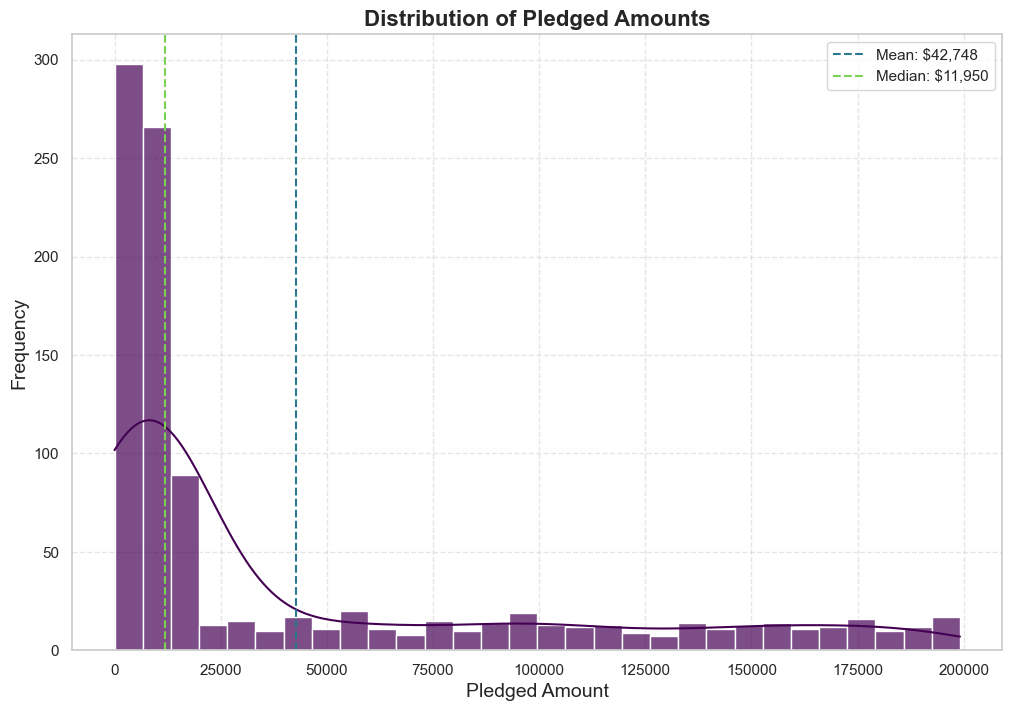

In [52]:
# Set the style and color palette of the visualization
sns.set(style="whitegrid", palette="pastel")

# Create the histogram
plt.figure(figsize=(12, 8))
hist_plot = sns.histplot(full_data_sql_df['pledged'], bins=30, kde=True, color='#440154', alpha=0.7)

# Add title and labels with improved fonts
plt.title('Distribution of Pledged Amounts', fontsize=16, fontweight='bold')
plt.xlabel('Pledged Amount', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Add annotations to show the mean and median
mean_value = full_data_sql_df['pledged'].mean()
median_value = full_data_sql_df['pledged'].median()
plt.axvline(mean_value, color='#2A788EFF', linestyle='dashed', linewidth=1.5, label=f'Mean: ${mean_value:,.0f}')
plt.axvline(median_value, color='#7AD151FF', linestyle='dashed', linewidth=1.5, label=f'Median: ${median_value:,.0f}')

# Add a legend
plt.legend()

# Show the plot
plt.show()

#### Backer by country

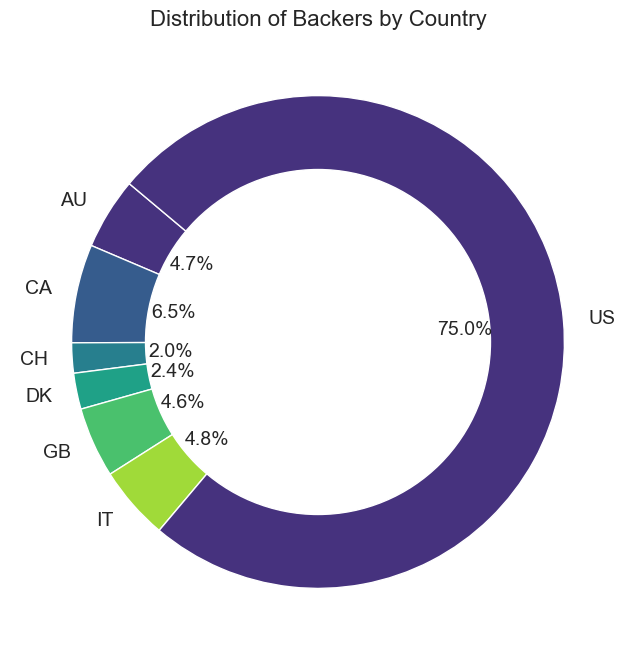

In [48]:
# Donut Chart: Distribution of backers across countries
backers_by_country_df = full_data_sql_df.groupby('country')['backers_count'].sum().reset_index()

# Define a color palette
colors = sns.color_palette('viridis')[0:len(backers_by_country_df)]

plt.figure(figsize=(8, 8))
plt.pie(backers_by_country_df['backers_count'], 
        labels=backers_by_country_df['country'], 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=colors,
        textprops={'fontsize': 14}, 
        wedgeprops=dict(width=0.4, edgecolor='w'))

# Draw a white circle at the center
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Title
plt.title('Distribution of Backers by Country', fontsize=16)
plt.show()

#### Pledged by category

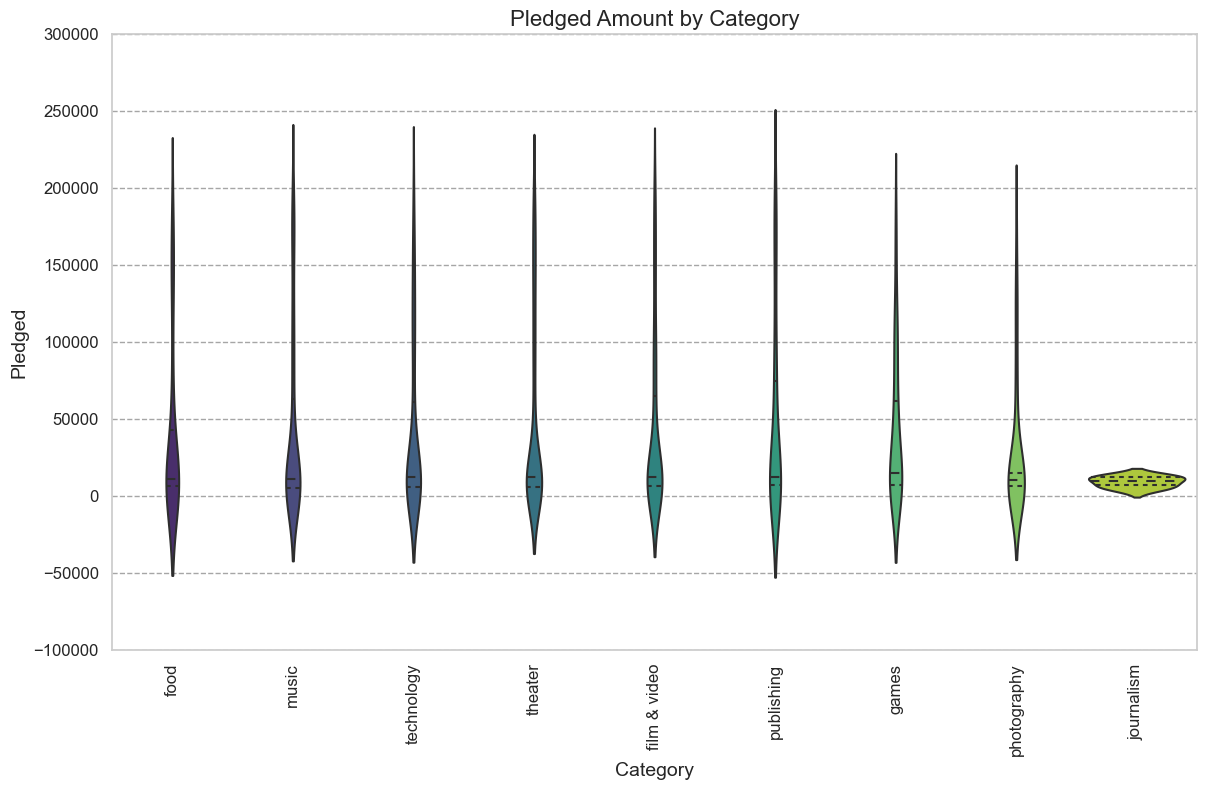

In [56]:
# Violin plot of goal vs pledged amount
# Create the canvas
plt.figure(figsize=(14, 8))

# Create the violin plot
sns.violinplot(x='category', y='pledged', data=full_data_sql_df, inner='quartile', linewidth=1.5, palette='viridis')

# Title and labels
plt.title('Pledged Amount by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Pledged', fontsize=14)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.ylim(-100000, 300000)

# Display grid lines
plt.grid(axis='y', color="gray", linestyle='--', alpha=0.7)

plt.show()

#### Goal vs Pledged

In [42]:
full_data_sql_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   first_name     1000 non-null   object        
 1   last_name      1000 non-null   object        
 2   email          1000 non-null   object        
 3   company_name   1000 non-null   object        
 4   description    1000 non-null   object        
 5   goal           1000 non-null   float64       
 6   pledged        1000 non-null   float64       
 7   outcome        1000 non-null   object        
 8   backers_count  1000 non-null   int64         
 9   country        1000 non-null   object        
 10  currency       1000 non-null   object        
 11  launched_date  1000 non-null   datetime64[ns]
 12  end_date       1000 non-null   datetime64[ns]
 13  staff_pick     1000 non-null   bool          
 14  spotlight      1000 non-null   bool          
 15  category       1000 no

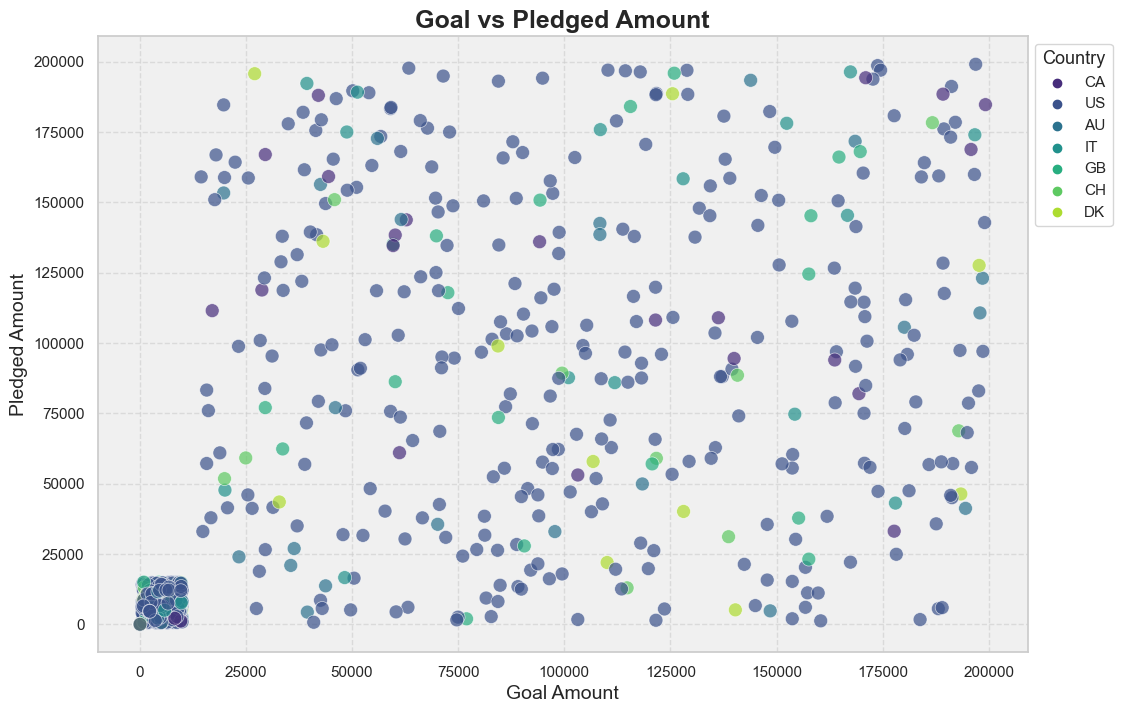

In [47]:
# Scatter Plot: Relationship between goal and pledged amount
plt.figure(figsize=(12, 8))

# Enhanced scatter plot
sns.scatterplot(x='goal', y='pledged', data=full_data_sql_df, hue='country', palette='viridis', s=100, alpha=0.7, edgecolor='w', linewidth=0.5)

# Title and labels with improved font sizes
plt.title('Goal vs Pledged Amount', fontsize=18, weight='bold')
plt.xlabel('Goal Amount', fontsize=14)
plt.ylabel('Pledged Amount', fontsize=14)

# Adding grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Legend customization
plt.legend(title='Country', title_fontsize='13', fontsize='11', loc='upper left', bbox_to_anchor=(1, 1))

# Background color
plt.gca().set_facecolor('#f0f0f0')

plt.show()

#### Top 10 Campaigns

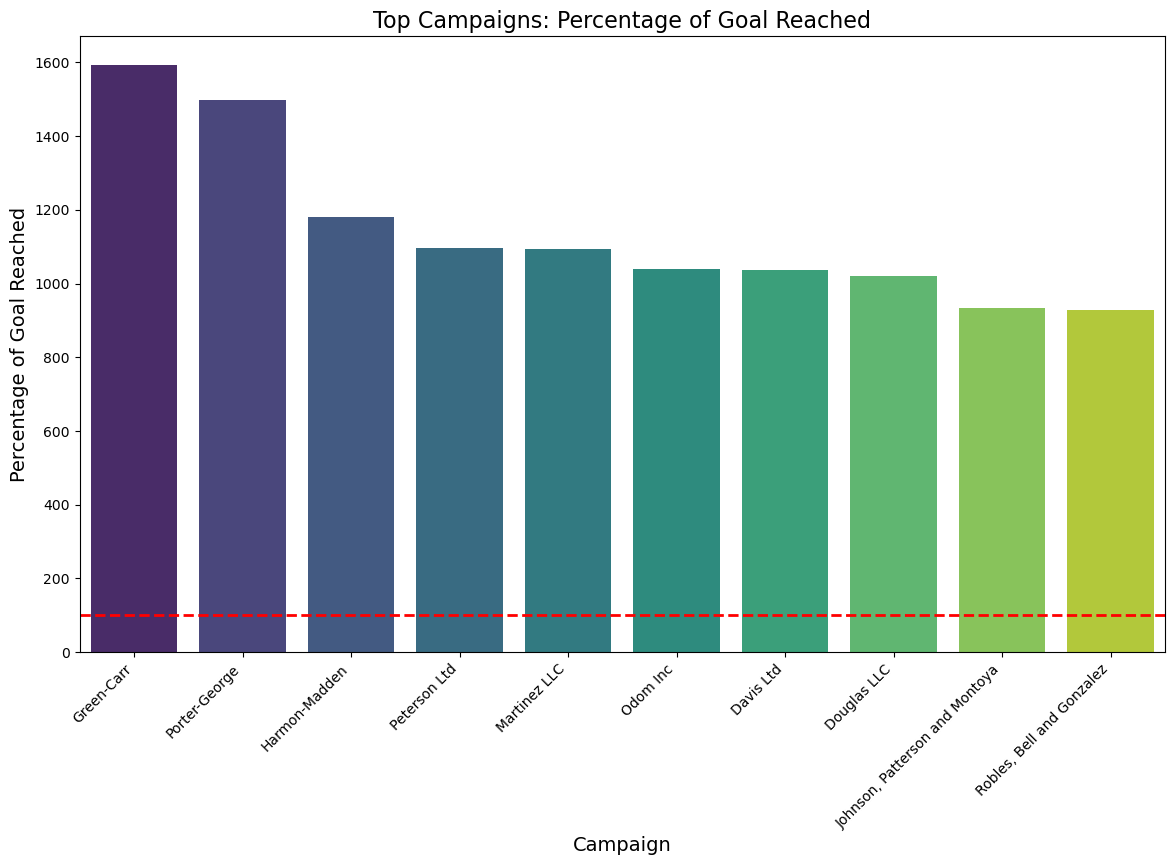

In [43]:
# Calculate percentage of goal reached
top_campaigns = 10

reached_goal_sql_df['percentage_reached'] = (reached_goal_sql_df['pledged'] / reached_goal_sql_df['goal']) * 100

# Sort and select top 10 campaigns
df_sorted = reached_goal_sql_df.sort_values(by='percentage_reached', ascending=False).head(top_campaigns)

# Progress Chart: Percentage of Goal Reached for top 10 Campaigns
plt.figure(figsize=(14, 8))
sns.barplot(x='company_name', y='percentage_reached', data=df_sorted, palette='viridis')
plt.axhline(y=100, color='r', linestyle='--', linewidth=2)
plt.title('Top Campaigns: Percentage of Goal Reached', fontsize=16)
plt.xlabel('Campaign', fontsize=14)
plt.ylabel('Percentage of Goal Reached', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

#### Linear regression of goals vs pledged

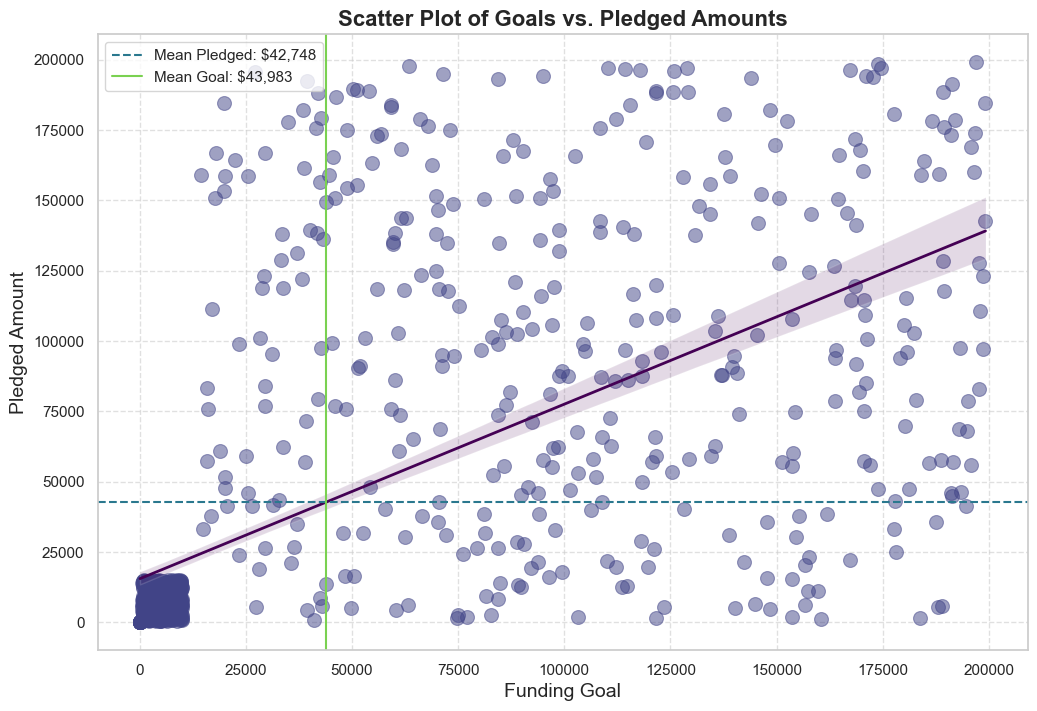

In [58]:
# Set the style and color palette of the visualization
sns.set(style="whitegrid", palette="muted")

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(x='goal', y='pledged', data=full_data_sql_df, alpha=0.5, s=100, color='#414487FF', edgecolor=None)

# Add a regression line for trend visualization
sns.regplot(x='goal', y='pledged', data=full_data_sql_df, scatter=False, color='#440154FF', line_kws={"linewidth":2, "linestyle":"solid"})

# Set the title and labels with improved fonts
plt.title('Scatter Plot of Goals vs. Pledged Amounts', fontsize=16, fontweight='bold')
plt.xlabel('Funding Goal', fontsize=14)
plt.ylabel('Pledged Amount', fontsize=14)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Add annotations for mean values
mean_goal = full_data_sql_df['goal'].mean()
mean_pledged = full_data_sql_df['pledged'].mean()
plt.axhline(mean_pledged, color='#2A788EFF', linestyle='dashed', linewidth=1.5, label=f'Mean Pledged: ${mean_pledged:,.0f}')
plt.axvline(mean_goal, color='#7AD151FF', linestyle='solid', linewidth=1.5, label=f'Mean Goal: ${mean_goal:,.0f}')

# Add a legend
plt.legend()

# Show the plot
plt.show()
